# Übung 2 - Aufgabe 1 - Klassifikation von Katzen und Hunden

In dieser Aufgabe soll der im Buch vorgestellte Datensatz verwendet werden, um Katzen und Hunde zu klassifizieren. Im Gegensatz zur vorherigen Aufgabe soll in dieser allerdings mittels fortgeschritteneren Netzen klassifiziert werden. Verwenden Sie dazu CNNs folgender Typen:

- Ein eigenes CNN angelehnt an das aus dem Buch
- Ein VGG Ihrer Wahl
- Ein ResNet Ihrer Wahl

Verwenden Sie zusätzlich ein Netz auf Basis von Vision Transformern. Vergleichen Sie die Ergebnisse. Gehen Sie auf diese Weise vor ist es sinnvoll sich für das Training eine wiederverwendbare Funktion zu schreiben.

Diese Aufgabe ist folgendermaßen aufgebaut:

1. Vornehmen nötiger Imports
2. Laden der Daten
3. Definition des eigenen CNN
4. Anlegen der neuronalen Netze
5. Training und Tests der neuronalen Netze

## 1. Nötige Imports vornehmen

Die folgende Code-Zelle importiert die notwendigen Bibliotheken, die im Folgenden benötigt werden.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

## 2. Trainingsdaten laden

Zunächst werden die Trainingsdaten aus dem Verzeichnis geladen. Hierbei können Sie wie im Buch beschrieben vorgehen.

In [2]:
# import train-test-split
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder


path = 'Data/'

train_data_dir = path + 'train/'
valid_data_dir = path + 'valid/'

# Definieren Sie die Transformationen, die auf die Bilder angewendet werden sollen (optional)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ändern Sie die Größe der Bilder auf 224x224 Pixel
    transforms.ToTensor(),           # Konvertieren Sie die Bilder in Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Erstellen Sie ImageFolder-Datasets für Trainings- und Validierungsdaten
train_set = ImageFolder(train_data_dir, transform=transform)
valid_set = ImageFolder(valid_data_dir, transform=transform)

# Definieren Sie die Batch-Größe für den DataLoader
batch_size = 32

print(train_set)
print(train_set.classes)

# Erstellen Sie DataLoader für Trainings- und Validierungsdaten
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0 )
valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=0)

# get example from train_loader
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)



Dataset ImageFolder
    Number of datapoints: 1149
    Root location: Data/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
['cat', 'dog']
torch.Size([32, 3, 224, 224])
torch.Size([32])


Im Folgenden kann eines der Bilder angezeigt werden.

In [3]:
!pip install torchsummary

In [4]:
print("test")


test


In [5]:
!git remote show 

origin


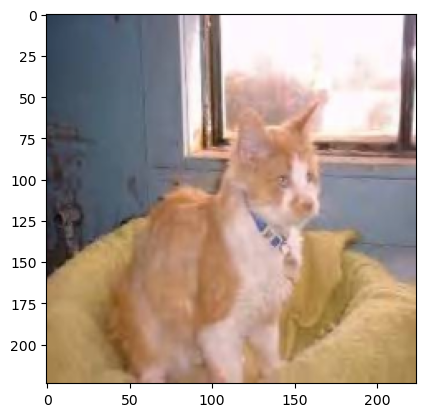

In [6]:
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))

    # WHY THIS operation, is this a reverse???
    # But I actually want to see the picture as the algorithm does
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)


imshow(images[0])

Die Daten werden nun einem Data Loader übergeben, welcher eine Zufallsverteilung und eine Organisation in "batches" vornimmt.


In [7]:
train_loader = train_loader
valid_loader = valid_loader

In [8]:
# Check for cuda
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True
    
print(is_cuda)

True


## 3. Definition des eigenen CNN

Nutzen Sie die vorgegebene Klasse CNN, um ein eigenes CNN zu implementieren. Aufgrund der Größe der Eingabebilder, sollte dieses mindestens 4-5 Conv2D-Schichten enthalten.

In [9]:
num_classes = 2
from torchsummary import summary

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        num_classes = 2
        # input size is 3x256x256
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        
        #self.fc1 = nn.Linear(in_features=20*62*62, out_features=500)
        self.fc1 = nn.Linear(in_features=56180, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=num_classes)

    def forward(self, x):
        # Implementieren Sie hier die Verbindung zwischen den Layern.
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) # Dropout only during training
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training) # Dropout only during training
        x = self.fc3(x)  # logits
        return F.log_softmax(x, dim=1)
    
model = CNN()
if is_cuda:
    model.cuda()
summary(model, (3, 224, 224))
out = model(images.cuda())
print(out.shape)
print(out)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 220, 220]             760
            Conv2d-2         [-1, 20, 106, 106]           5,020
         Dropout2d-3         [-1, 20, 106, 106]               0
            Linear-4                  [-1, 500]      28,090,500
            Linear-5                   [-1, 50]          25,050
            Linear-6                    [-1, 2]             102
Total params: 28,121,432
Trainable params: 28,121,432
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 7.13
Params size (MB): 107.27
Estimated Total Size (MB): 114.97
----------------------------------------------------------------
torch.Size([32, 2])
tensor([[-0.6964, -0.6899],
        [-0.7005, -0.6859],
        [-0.6982, -0.6881],
        [-0.6971, -0.6892],
        [-0.6569, -0.7308],


## 4. Anlegen der neuronalen Netze

Legen Sie in der nächsten Zelle die vier Netze der vorgegebenen Typen an. Denken Sie daran die Ausgabe auf die Anzahl der vorliegenden Klassen anzupassen. Beim VGG lässt sich dies im letzten Layer der Sequenz "classifier" und beim Vision Transformer im letzten Layer der Sequenz "heads" setzen. Das ResNet können Sie wie im Kapitel 3 beschrieben anpassen.

In [11]:
def prepare_vgg(model, n_classes):

    model.classifier[6] = nn.Linear(4096, n_classes)

    return model

def prepare_resnet(model, n_classes):
    # Code für das Setzen des letzten ResNet Layers
    return model

def prepare_vit(model, n_classes):
    # Code für das Setzen des letzten VisionTransformer Layers
    return model

cnn = CNN()
# Hier Ihre Modelle Initialisieren und vorbereiten.
vgg = prepare_vgg(models.vgg16(pretrained=True), num_classes)

vgg_model = models.vgg16()
#vgg_model.load_state_dict(torch.load("models/vgg16-397923af.pth"))
vgg = prepare_vgg(vgg_model, 2)

if is_cuda:
    vgg.cuda()
summary(vgg, (3, 224, 224))
resnet = None
vit = None
vgg

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
torch.cuda.is_available()

True

## 5. Training des Modells

Schreiben Sie in die Funktion "train_model" die Trainingslogik der neuronalen Netze. Hier können Sie ähnlich wie bei der MNIST-Aufgabe vorgehen. Die Funktion "plot_results" kann Genauigkeit und Verlust als Plot darstellen.

In [49]:
def plot_results(epochs, training_acc, testing_acc, training_loss, testing_loss):
    plt.plot(range(epochs), training_acc, label="train_acc")
    plt.plot(range(epochs), testing_acc, label="valid_acc")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.show()

    plt.plot(range(epochs), training_loss, label="train_loss")
    plt.plot(range(epochs), testing_loss, label="valid_loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

def train_model(model, epochs=20, learning_rate=0.001):
    # Hier Initialiserung der Verlustfunktion vornehmen
    loss_fn = nn.NLLLoss()
    # Hier Initialiserung des Optimierers vornehmen
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.5)

    training_loss = []
    testing_loss = []
    training_acc = []
    testing_acc = []

    if torch.cuda.is_available():
        model = model.to("cuda")

    with tqdm(range(epochs)) as iterator:
        for epoch in iterator:
            running_train_acc = []
            running_train_loss = []
            
            sum_items = 0
            model.train()
            for images, labels in train_loader:
                if torch.cuda.is_available():
                    images = images.to("cuda")
                    labels = labels.to("cuda")

                # Hier die Ausführung des Trainings einer einzelnen Batch ergänzen
                # Bitte an die Aktualisierung von train_loss und train_acc denken!
                y_hat = model(images)
                # argmax gibt den Index des höchsten Wertes zurück
                _, predicted = torch.max(y_hat.data, 1)
                loss = loss_fn(y_hat, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # accuracy berechnen
                correct_or_not = (predicted == labels).float()
                tmp_acc = torch.mean(correct_or_not).item()
                running_train_acc.append(tmp_acc)
                running_train_loss.append(loss.item())
                #sum_items += len(labels)

                


            training_acc.append(np.mean(running_train_acc))
            training_loss.append(np.mean(running_train_loss))

            running_test_acc = []
            running_test_loss = []
            model.eval()
            for images, labels in valid_loader:
                if torch.cuda.is_available():
                    images = images.to("cuda")
                    labels = labels.to("cuda")
                # Hier die Ausführung des Tests einer einzelnen Batch ergänzen
                # Bitte an die Aktualisierung von test_loss und test_acc denken!
                y_hat = model(images)
                # argmax gibt den Index des höchsten Wertes zurück
                loss = loss_fn(y_hat, labels)
                _, predicted = torch.max(y_hat.data, 1)
                # accuracy berechnen
                running_test_acc.append(torch.mean((predicted == labels).float()).item())
                running_test_loss.append(loss.item())


            testing_acc.append(np.mean(running_test_acc))
            testing_loss.append(np.mean(running_test_loss))

            iterator.set_postfix_str(f"train_acc: {np.mean(running_train_acc):.2f} test_acc: {np.mean(running_test_acc):.2f} train_loss: {np.mean(running_train_loss):.2f} test_loss: {np.mean(running_test_loss):.2f}")

            #if epoch == 0 or epoch % 5 == 0:
            #    # PRINT
            #    print(f"Epoch: {epoch}")
            #    print(f"Training accuracy: {train_acc/sum_items:.2f}")
            #    print(f"Training loss: {train_loss/sum_items:.2f}")
            #    print(f"Testing accuracy: {test_acc/len(valid_set):.2f}")
            #    print(f"Testing loss: {test_loss/len(valid_set):.2f}")

    

    plot_results(epochs, training_acc, testing_acc, training_loss, testing_loss)


Wenn Sie Ihre Funktion "train_model" korrekt implementiert haben und Ihre Modelle definiert sind, können Sie ihre Modelle in den folgenden vier Zellen trainieren lassen. Da der Datensatz recht groß ist, würde ich ein Training auf 3-10 Epochen begrenzen. Falls Sie eine Cuda-fähige Grafikkarten besitzen, können Sie auch länger trainieren.

In [ ]:
train_model(cnn)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
Training accuracy: 0.52
Training loss: nan
Testing accuracy: 0.46
Testing loss: nan
Epoch: 5
Training accuracy: 0.51
Training loss: nan
Testing accuracy: 0.46
Testing loss: nan
Epoch: 10
Training accuracy: 0.51
Training loss: nan
Testing accuracy: 0.46
Testing loss: nan
Epoch: 15
Training accuracy: 0.51
Training loss: nan
Testing accuracy: 0.46
Testing loss: nan


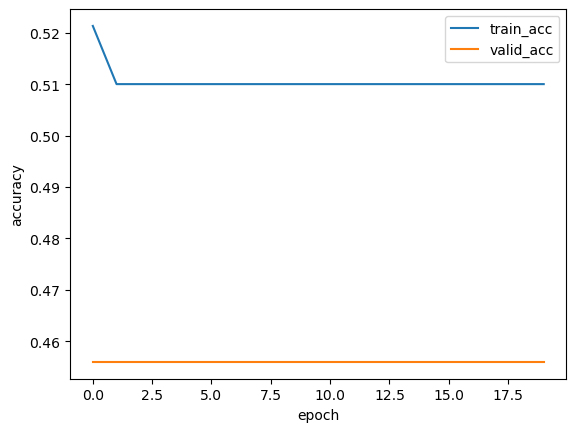

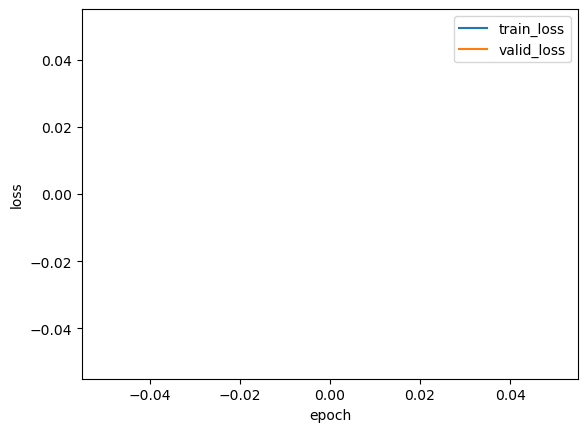

In [30]:
train_model(vgg)

In [ ]:
train_model(resnet)

In [ ]:
train_model(vit)